In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import cPickle as pickle
from spiketopics.helpers import *

%matplotlib inline
sns.set_style('darkgrid')

# Load in data

In [2]:
infile = 'data/fitted_model_object.pkl'
gpm = pickle.load(open(infile, 'rb'))
dt = 0.020

In [3]:
gpm.Nframe.head()

,unit,time,count,lam0,lam1
0,0,0,0,-0.330602,-0.309942
1,0,0,0,-0.330602,-0.309942
2,0,0,1,-0.385702,-0.427034
3,0,0,0,-0.330602,-0.309942
4,0,0,1,-0.385702,-0.427034


In [4]:
if gpm.regressors:
    gpm.Xframe.head()

# Plot inferred categories as matrix

In [5]:
xi = gpm.nodes['HMM'].nodes['z'].z[1].copy()
T, K = xi.shape
print xi.shape

(624, 10)


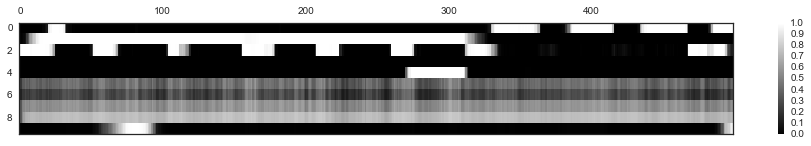

In [6]:
matshow(xi[:500].T, vmin=0, vmax=1);
plt.colorbar();

## Make $\xi$ dataframe:

In [7]:
xif = pd.DataFrame(xi)
xif.columns = ['Z' + str(k) for k in range(K)]
xif.index.name = 'time'
xif = xif.reset_index()

# Posteriors for effects

## Baselines

In [8]:
bl = gpm.nodes['baseline']
unit_baseline_means = bl.expected_x() / dt

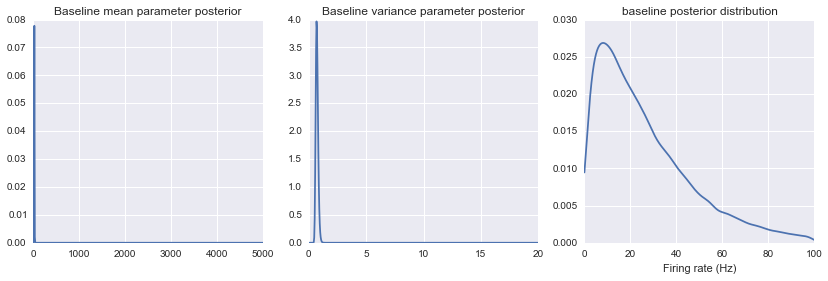

In [9]:
plt.figure(figsize=(14, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 5000, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean parameter posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 20, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title('baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 100);

## Regressors

In [10]:
if gpm.regressors:
    plt.figure(figsize=(8, 6));
    inferred_means = gpm.nodes['fr_regressors'].expected_x()
    R = inferred_means.shape[1]
    for r in xrange(R):
        plt.hist(inferred_means[:, r], bins=50, normed=True, alpha=0.25, label='X' + str(r))
    plt.title('Regression effects');
    plt.legend()
    plt.ylim(0, 5);
    plt.xlim(0, 5);

## Latent Categories

In [11]:
frn = gpm.nodes['fr_latents']
fr_mean_effect = frn.expected_x()

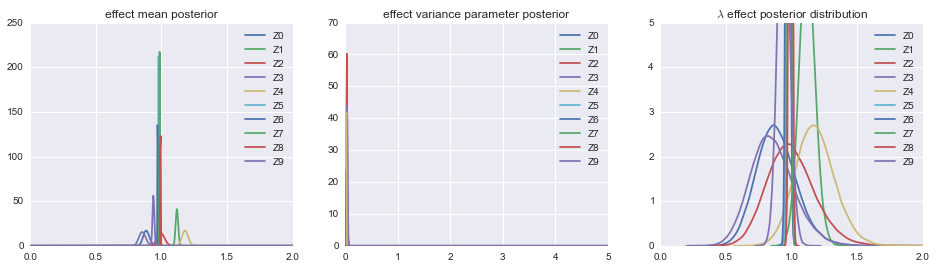

In [12]:
plt.figure(figsize=(16, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 5, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlim(0, 2);
plt.ylim(0, 5);

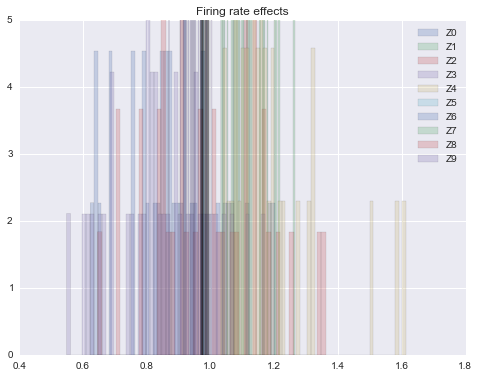

In [13]:
plt.figure(figsize=(8, 6))

inferred_effects = gpm.nodes['fr_latents'].expected_x()
for kk in xrange(K):
    plt.hist(inferred_effects[..., kk], bins=50, normed=True, alpha=0.25, label='Z' + str(kk));
plt.legend();
plt.title('Firing rate effects');
plt.ylim(0, 5);

## Overdispersion

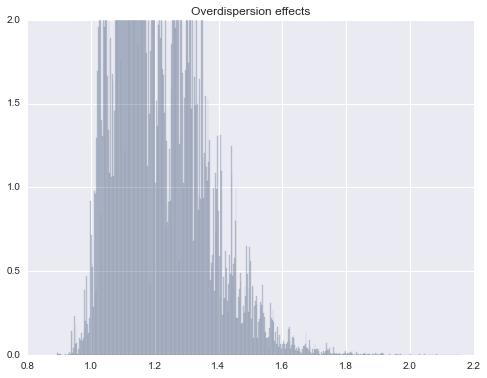

In [14]:
if gpm.overdispersion:
    plt.figure(figsize=(8, 6))

    inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.title('Overdispersion effects');
    plt.ylim(0, 2);

# Load and prepare coded features:

Our goal here is to load the ethogram, join it to the inferred ethogram, and perform some comparisons to see if any of our discovered categories match hand-labeled categories from the ethogram.

In [15]:
codefile = 'data/roitman_fd_data.csv'
code = pd.read_csv(codefile).groupby('utime').mean().reset_index()

In [16]:
code.head()

,utime,count,time,trial,stimulus,coherence,fixation_on,fixation,target_on,stim_on,...,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xinto,Xout,into_RF
0,0,0.595890,0,32.89726,71,0,0,52.547945,460.438356,903.780822,...,0,0,0,0,0,0,0,0,0,1
1,1,0.780822,20,32.89726,71,0,0,52.547945,460.438356,903.780822,...,1,1,0,0,0,0,0,1,0,1
2,2,0.636986,40,32.89726,71,0,0,52.547945,460.438356,903.780822,...,1,1,0,0,0,0,0,1,0,1
3,3,0.746575,60,32.89726,71,0,0,52.547945,460.438356,903.780822,...,1,1,0,0,0,0,0,1,0,1
4,4,0.623288,80,32.89726,71,0,0,52.547945,460.438356,903.780822,...,1,1,0,0,0,0,0,1,0,1


In [17]:
# convert bools to floats
for col in code:
    code[col] = code[col].astype('float')

In [18]:
# merge labeled and inferred etho on movie and frame columns
edf = pd.merge(code, xif, how='right', left_on='utime', right_on='time')
edf.columns

Index([u'utime', u'count', u'time_x', u'trial', u'stimulus', u'coherence', u'fixation_on', u'fixation', u'target_on', u'stim_on', u'stim_off', u'fixation_off', u'saccade', u'reward', u'choice', u'correct', u'unit', u'Xstim', u'Xcoh0', u'Xcoh32', u'Xcoh64', u'Xcoh128', u'Xcoh256', u'Xcoh512', u'Xinto', u'Xout', u'into_RF', u'time_y', u'Z0', u'Z1', u'Z2', u'Z3', u'Z4', u'Z5', u'Z6', u'Z7', u'Z8', u'Z9'], dtype='object')

In [19]:
# get rid of categories that are either identifiers or have non-binary entries
to_drop = [col for col in edf.columns if not ('Z' in col or 'X' in col)]
edf = edf.drop(to_drop, axis=1)

In [20]:
edf.head()

,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xinto,Xout,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
0,0,0,0,0,0,0,0,0,0,0.000317,0.008500,0.916539,2.127640e-04,0.000043,0.043482,0.043514,0.041877,0.039544,0.005357
1,1,1,0,0,0,0,0,1,0,0.000043,0.015053,0.992676,2.591838e-06,0.000042,0.224006,0.132962,0.344569,0.349573,0.002221
2,1,1,0,0,0,0,0,1,0,0.000250,0.020277,0.998010,1.418449e-05,0.000005,0.354225,0.222341,0.501415,0.537119,0.001951
3,1,1,0,0,0,0,0,1,0,0.000005,0.038064,0.999969,4.567693e-08,0.000018,0.358846,0.221673,0.522339,0.621438,0.001659
4,1,1,0,0,0,0,0,1,0,0.000125,0.077397,0.999640,1.585686e-06,0.000006,0.412957,0.267347,0.568470,0.680596,0.002030


# Compare actual and predicted firing

In [21]:
# make dataframe of firing rates
meancnt = code.groupby(['time', 'stimulus']).mean()['count'].unstack(level=1)
fr = pd.rolling_mean(meancnt, 9, min_periods=1, center=True) / dt

In [22]:
# calculate predicted firing rate
pred_mat = unit_baseline_means[np.newaxis, :] * np.exp(xi.dot(np.log(fr_mean_effect.T)))
preds = np.mean(pred_mat, axis=1)  # mean across units
code['pred_fr'] = preds * np.mean(gpm.nodes['overdispersion'].expected_x())

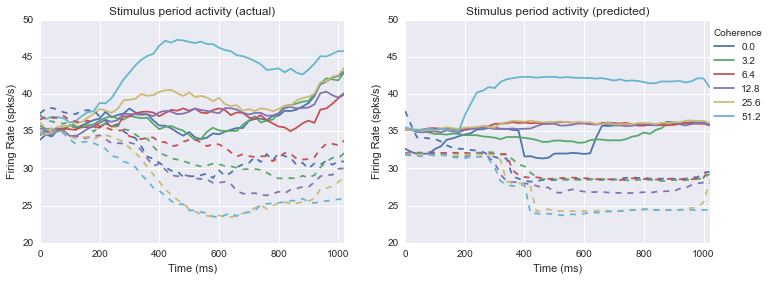

In [23]:
plt.figure(figsize=(12, 4))

##### first, do actual
ax = plt.subplot(1, 2, 1)

# label cols according to coherence, RF
coh_tbl = code[['stimulus', 'coherence', 'into_RF']].drop_duplicates()
colnames = []
for idx, row in coh_tbl.iterrows():
    coh_str = str(row['coherence'] / 10)
    colnames.append(coh_str)

fr.columns = colnames
midpt = int(fr.shape[1] / 2)
fr.iloc[:, :midpt].plot(ax=ax, legend=False)
fr.iloc[:, midpt:].plot(ax=ax, legend=False, linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (spks/s)')
plt.title('Stimulus period activity (actual)')
yl = plt.ylim()

##### now do predicted
ax = plt.subplot(1, 2, 2)

# data frame of predicted firing for each stimulus
pred_df = code.groupby(['time', 'stimulus']).mean()['pred_fr'].unstack(level=1)

# plot
midpt = int(pred_df.shape[1] / 2)
pred_df.iloc[:, :midpt].plot(ax=ax, legend=False)
pred_df.iloc[:, midpt:].plot(ax=ax, legend=False, linestyle='--')
plt.ylim(yl)
ax.legend(colnames[:midpt], bbox_to_anchor=(1.2, 1.00), title='Coherence');
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (spks/s)')
plt.title('Stimulus period activity (predicted)');

# View results:

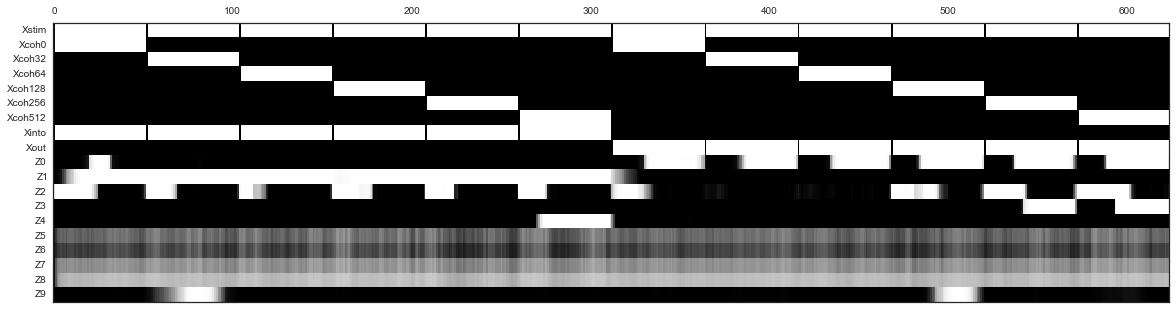

In [24]:
# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(None)
matshow(edf.iloc[trng].values.T, vmin=0, vmax=1);
col_labels = edf.columns
plt.yticks(xrange(len(col_labels)), col_labels);
plt.gcf().set_size_inches([20, 5])

## Overlap analysis:

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [25]:
match = (edf.T.dot(edf) + (1 - edf.T).dot(1 - edf)) / T
mismatch = (edf.T.dot(1 - edf) + (1 - edf.T).dot(edf)) / T
overlap = np.maximum(match, mismatch)

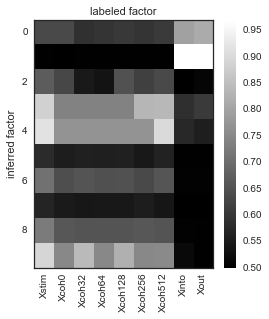

In [26]:
row_labels = edf.columns[:-K]
matshow(overlap.values[-K:,:-K]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [27]:
overlap.iloc[-K:, :]

,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xinto,Xout,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
Z0,0.635100,0.636123,0.591476,0.596095,0.605826,0.598869,0.606660,0.795738,0.814942,0.980066,0.802897,0.555522,0.747658,0.587474,0.532247,0.574283,0.516908,0.568532,0.646372
Z1,0.502285,0.501551,0.502730,0.502722,0.502140,0.502760,0.502631,0.969789,0.969284,0.802897,0.984861,0.503706,0.594065,0.568710,0.502718,0.503778,0.501819,0.501418,0.509543
Z2,0.669581,0.631630,0.547206,0.535154,0.648905,0.619186,0.636812,0.501640,0.509587,0.555522,0.503706,0.960201,0.598302,0.608954,0.528323,0.572193,0.521725,0.577156,0.601466
Z3,0.883917,0.739696,0.739699,0.739687,0.739691,0.834139,0.838903,0.586821,0.606915,0.747658,0.594065,0.598302,0.998110,0.836436,0.569759,0.679250,0.554276,0.687822,0.819298
Z4,0.915736,0.770798,0.769812,0.769804,0.769836,0.769821,0.900481,0.573973,0.555588,0.587474,0.568710,0.608954,0.836436,0.996036,0.573255,0.690944,0.559349,0.702637,0.846567
Z5,0.579601,0.553493,0.562272,0.558366,0.559740,0.545063,0.564186,0.502309,0.502771,0.532247,0.502718,0.528323,0.569759,0.573255,0.523797,0.547424,0.505132,0.535304,0.574261
Z6,0.710267,0.643698,0.654545,0.648692,0.651644,0.634620,0.656692,0.505490,0.504651,0.574283,0.503778,0.572193,0.679250,0.690944,0.547424,0.608084,0.523464,0.598731,0.686943
Z7,0.567950,0.548504,0.542715,0.544755,0.544391,0.553303,0.541442,0.500718,0.500071,0.516908,0.501819,0.521725,0.554276,0.559349,0.505132,0.523464,0.514133,0.535626,0.553798
Z8,0.727250,0.660405,0.655345,0.655343,0.655943,0.661363,0.654378,0.504769,0.502403,0.568532,0.501418,0.577156,0.687822,0.702637,0.535304,0.598731,0.535626,0.612969,0.691803
Z9,0.893983,0.750437,0.842874,0.749868,0.824094,0.750028,0.753726,0.516694,0.503188,0.646372,0.509543,0.601466,0.819298,0.846567,0.574261,0.686943,0.553798,0.691803,0.963966


## Mutual Information

In [28]:
mi_mat = mutual_information_matrix(edf.iloc[:, :-K].values, edf.iloc[:, -K:].values)

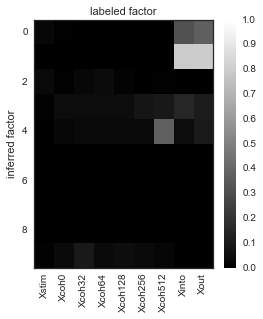

In [34]:
row_labels = edf.columns[:-K]
matshow(mi_mat.T, vmin=0, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [33]:
pd.DataFrame(mi_mat.T, columns=row_labels)

,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xinto,Xout
0,0.030198,0.007711,0.001138,0.000437,0.000035,0.000175,0.000067,0.322684,0.371169
1,0.000013,0.000076,0.000005,0.000005,0.000001,0.000005,0.000004,0.796009,0.798095
2,0.036519,0.004811,0.029240,0.043924,0.013382,0.001274,0.006939,-0.009087,-0.025590
3,0.011359,0.048411,0.048376,0.048524,0.048467,0.083787,0.095962,0.149171,0.107145
4,0.000576,0.030863,0.037236,0.037323,0.036982,0.037133,0.377669,0.050104,0.104858
5,0.000311,0.000080,0.000197,0.000015,0.000055,0.000967,0.000362,0.000278,0.000150
6,0.000241,0.000172,0.000363,0.000003,0.000110,0.001646,0.000642,0.000420,0.000147
7,0.000411,0.000036,0.000081,0.000014,0.000022,0.000342,0.000152,-0.000204,-0.000094
8,0.000700,0.000077,0.000043,0.000043,0.000023,0.000136,0.000091,-0.001316,-0.000408
9,0.008107,0.039119,0.099623,0.042381,0.052935,0.041384,0.026606,-0.041881,-0.039250
